In [50]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer
import warnings
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score, f1_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_curve, auc
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score


df = pd.read_csv('Cardiovascular_Disease_Dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   patientid          1000 non-null   int64  
 1   age                1000 non-null   int64  
 2   gender             1000 non-null   int64  
 3   chestpain          1000 non-null   int64  
 4   restingBP          1000 non-null   int64  
 5   serumcholestrol    1000 non-null   int64  
 6   fastingbloodsugar  1000 non-null   int64  
 7   restingrelectro    1000 non-null   int64  
 8   maxheartrate       1000 non-null   int64  
 9   exerciseangia      1000 non-null   int64  
 10  oldpeak            1000 non-null   float64
 11  slope              1000 non-null   int64  
 12  noofmajorvessels   1000 non-null   int64  
 13  target             1000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 109.5 KB


# EDA

In [57]:
# check for class imbalance.

#df['target'].value_counts().plot(kind='bar')
df['target'].value_counts()

1    580
0    420
Name: target, dtype: int64

In [58]:
df['gender'].value_counts()

1    765
0    235
Name: gender, dtype: int64

<Axes: xlabel='oldpeak', ylabel='Count'>

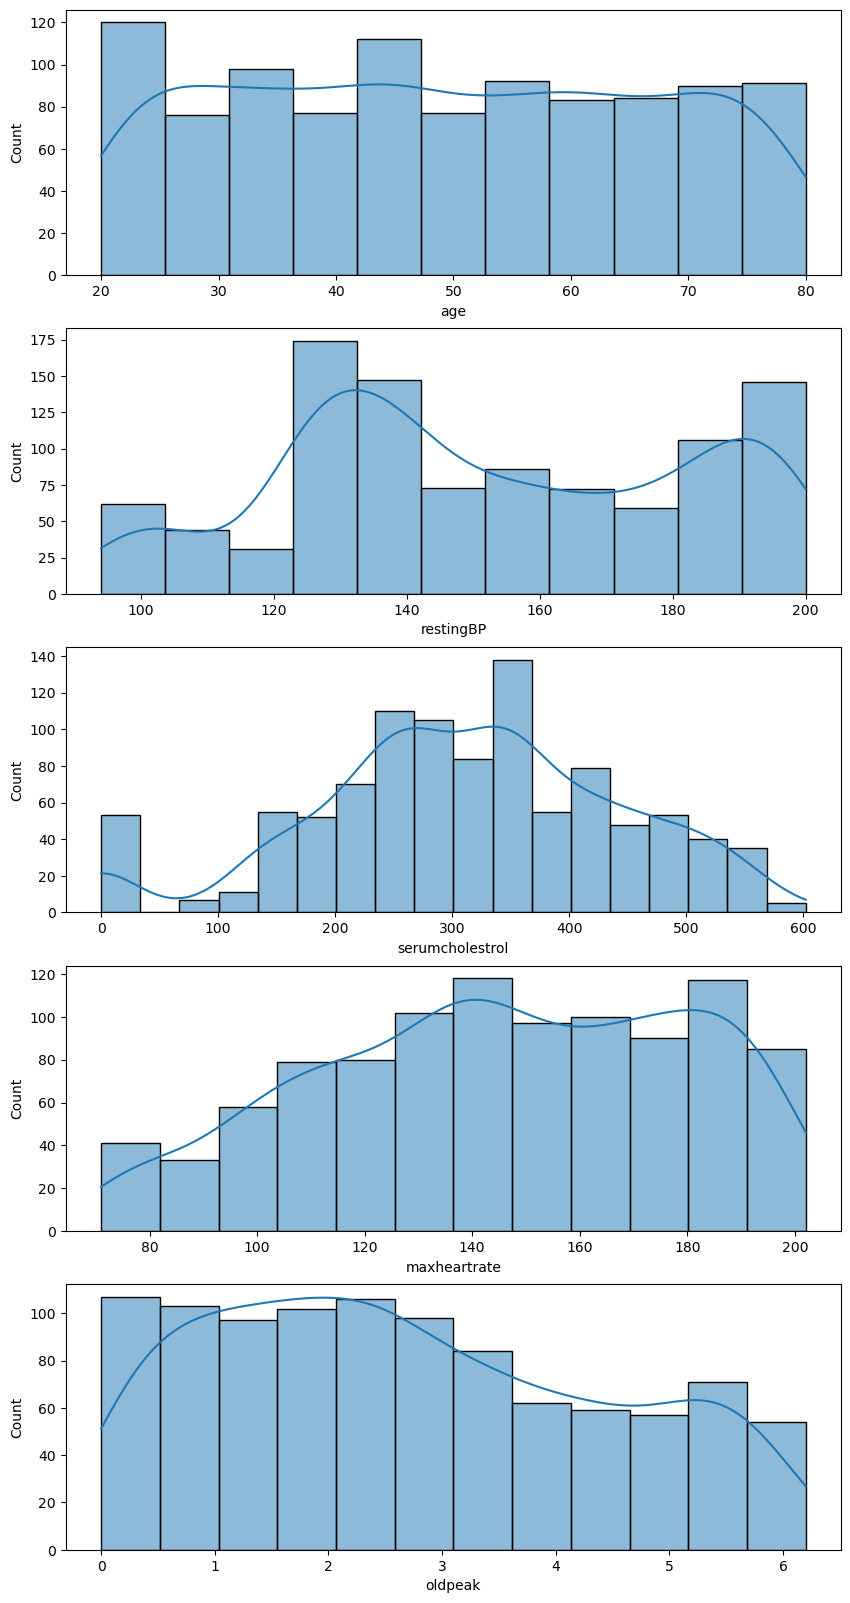

In [59]:
# class distribution for continuous features 

num_columns = df.select_dtypes(include=['float64','int64']).columns
num_columns = num_columns.drop(['patientid','target'])
num_columns

fig, axes = plt.subplots(5,1, figsize=(10,20))

#for i, col in enumerate(num_columns):
 #   sns.histplot(df[col], kde=True, ax=axes[i])
  #  axes[i].set_title(f"distribution of {col}")
    

sns.histplot(df['age'], kde=True, ax=axes[0])


sns.histplot(df['restingBP'], kde=True, ax=axes[1])
sns.histplot(df['serumcholestrol'], kde=True, ax=axes[2])


sns.histplot(df['maxheartrate'], kde=True, ax=axes[3])

sns.histplot(df['oldpeak'], kde=True, ax=axes[4])


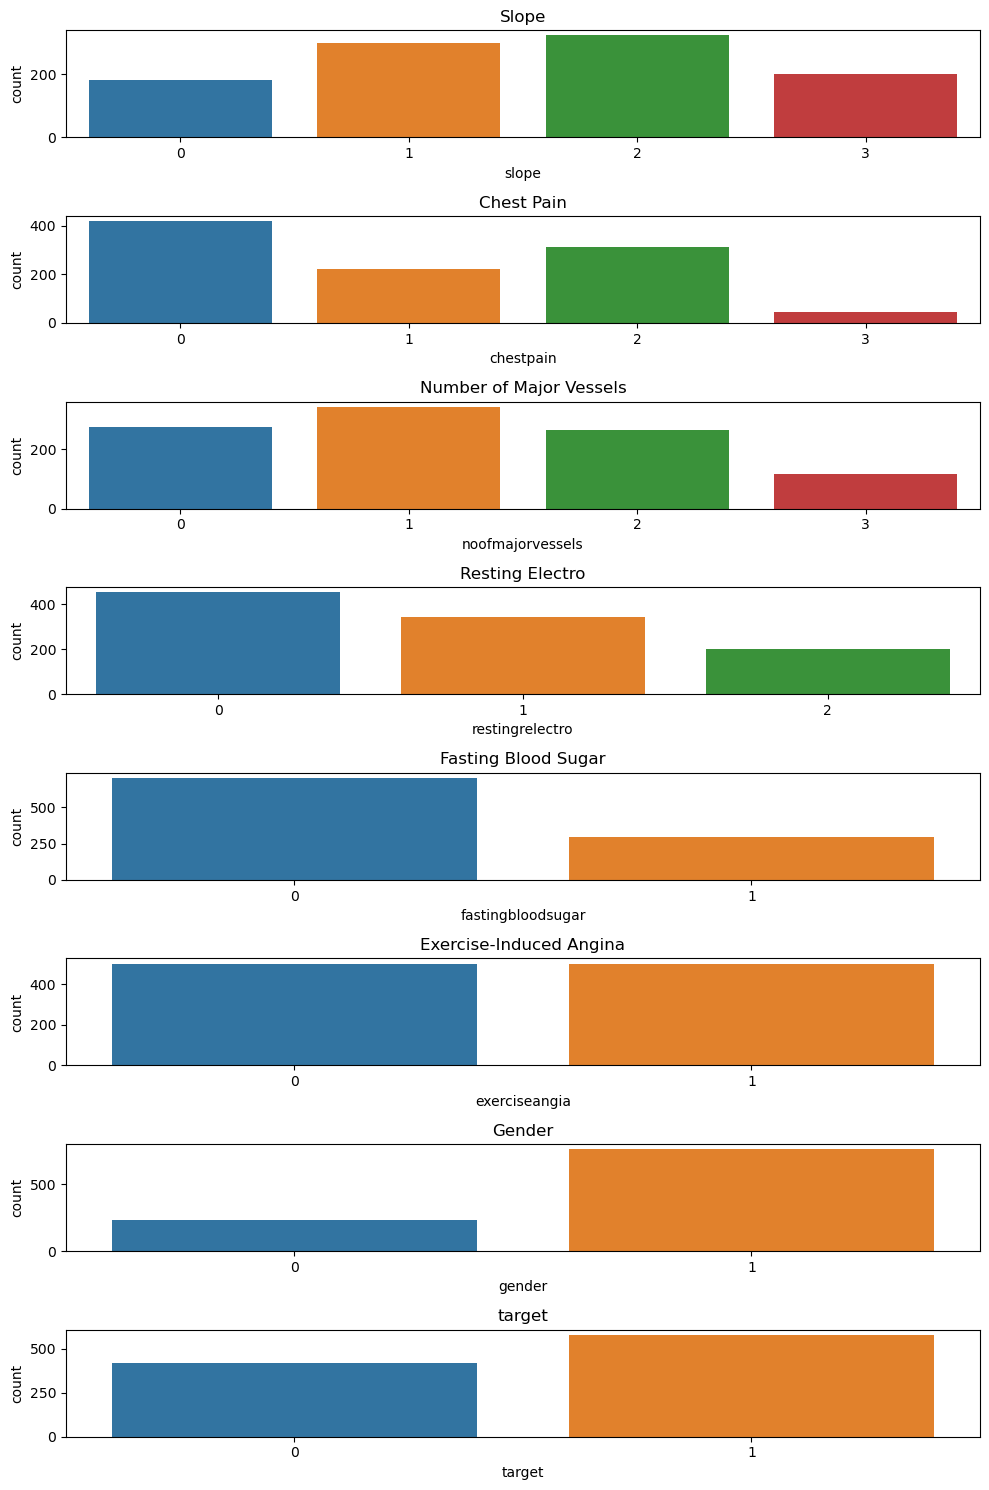

In [60]:
# class balances in categorical features

fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(10, 15))

sns.countplot(x='slope', data=df, ax=axes[0])
axes[0].set_title('Slope')

sns.countplot(x='chestpain', data=df, ax=axes[1])
axes[1].set_title('Chest Pain')

sns.countplot(x='noofmajorvessels', data=df, ax=axes[2])
axes[2].set_title('Number of Major Vessels')

sns.countplot(x='restingrelectro', data=df, ax=axes[3])
axes[3].set_title('Resting Electro')

sns.countplot(x='fastingbloodsugar', data=df, ax=axes[4])
axes[4].set_title('Fasting Blood Sugar')

sns.countplot(x='exerciseangia', data=df, ax=axes[5])
axes[5].set_title('Exercise-Induced Angina')

sns.countplot(x='gender', data=df, ax=axes[6])
axes[6].set_title('Gender')

sns.countplot(x='target', data=df, ax=axes[7])
axes[7].set_title('target')

plt.tight_layout()
plt.show()


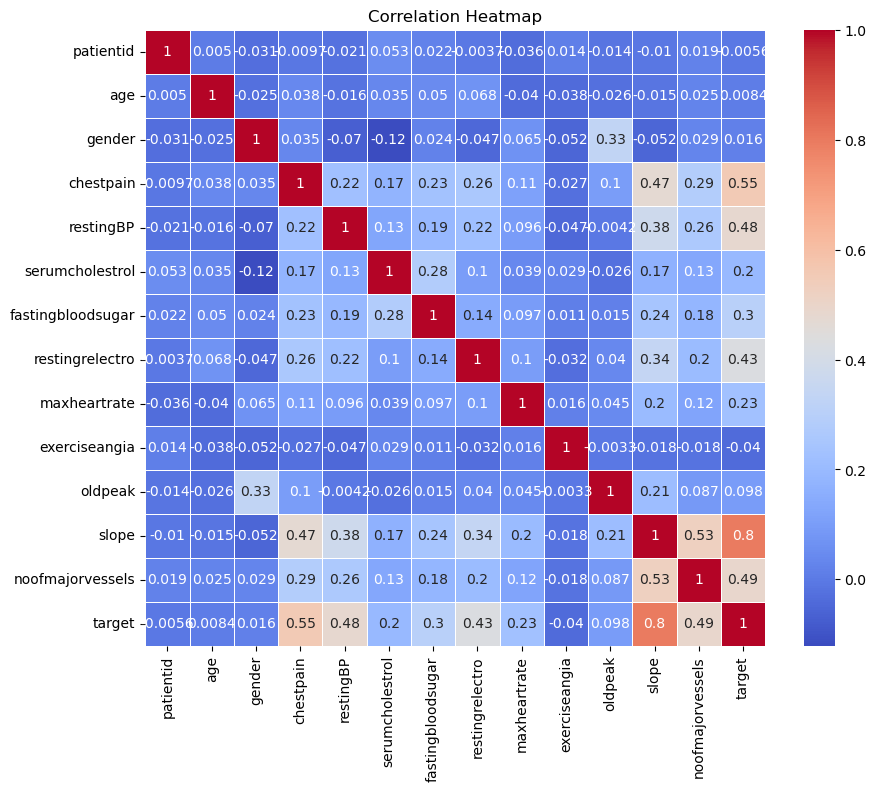

In [61]:
# showing the correlations of features to eachother

correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.savefig('heatmap.png')
plt.title('Correlation Heatmap')
plt.show()

# feature importance and selection

              Feature  Importance
11              slope    0.423450
4           restingBP    0.132195
3           chestpain    0.125563
5     serumcholestrol    0.066139
12   noofmajorvessels    0.062049
7     restingrelectro    0.047032
8        maxheartrate    0.044807
10            oldpeak    0.029057
1                 age    0.019817
2              gender    0.016465
0           patientid    0.016273
6   fastingbloodsugar    0.014410
9       exerciseangia    0.002742


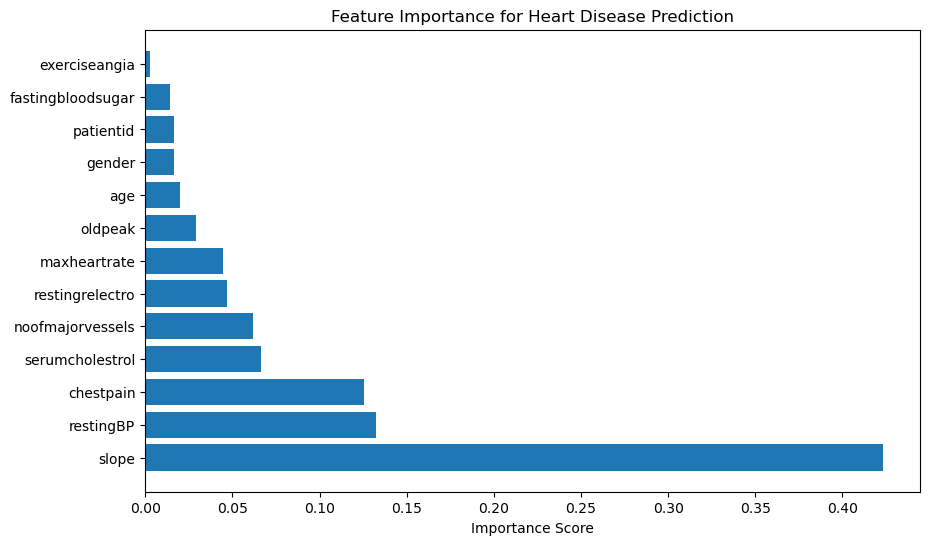

In [51]:
X = df.drop('target', axis=1)  
y = df['target']  

rfmodel = RandomForestClassifier()
rfmodel.fit(X, y)
importances = rfmodel.feature_importances_

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importances)
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance Score')
plt.title('Feature Importance for Heart Disease Prediction')
plt.show()

In [5]:
model = RandomForestClassifier(random_state=42)

# sequential forward selection with 5-10 features
for num_features in range(5, 13):
    print(f"\nselecting {num_features} features")
    
    sfs = SequentialFeatureSelector(model, n_features_to_select=num_features, direction='forward', cv=5)
    
    sfs.fit(X, y)
    selected_features = sfs.get_support()    
    print(f"selected features: {selected_features}")
    
    # transform the data to keep only the selected features
    X_selected = sfs.transform(X)
    
    # evaluate the model using the selected features with cv
    cv_scores = cross_val_score(model, X_selected, y, cv=5, scoring='accuracy')
    print(f"cv scores with {num_features} features: {cv_scores}")
    print(f"mean cv score: {cv_scores.mean()}")


selecting 5 features
selected features: [False False False False False  True  True  True False False False  True
  True]
cv scores with 5 features: [0.945 0.965 0.96  0.96  0.93 ]
mean cv score: 0.952

selecting 6 features
selected features: [False False  True False False  True  True  True False False False  True
  True]
cv scores with 6 features: [0.965 0.97  0.955 0.975 0.955]
mean cv score: 0.9640000000000001

selecting 7 features
selected features: [False False  True False  True  True  True  True False False False  True
  True]
cv scores with 7 features: [0.96  0.98  0.96  0.985 0.955]
mean cv score: 0.968

selecting 8 features
selected features: [False False  True  True  True  True  True  True False False False  True
  True]
cv scores with 8 features: [0.985 0.99  0.985 0.98  0.965]
mean cv score: 0.9810000000000001

selecting 9 features
selected features: [False False  True  True  True  True  True  True  True False False  True
  True]
cv scores with 9 features: [0.975 0.995 0.97

## so 8 features have been found to provide the highest accuracy across 5 folds of cv

In [6]:
# extract the features and transform the dataframe

sfs = SequentialFeatureSelector(model, n_features_to_select=8, direction='forward', cv=5)
sfs.fit(X, y)
selected_features = sfs.get_support()    
print(f"selected features: {selected_features}")

selected features: [False False  True  True  True  True  True  True False False False  True
  True]


In [7]:
selected_features
x = X.columns[selected_features]
X_selected = X[x]
X_selected.head()

,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,slope,noofmajorvessels
0,1,2,171,0,0,1,3,3
1,1,0,94,229,0,1,1,1
2,1,2,133,142,0,0,1,0
3,1,0,138,295,1,1,2,2
4,1,1,199,0,0,2,3,2


In [52]:
# splitting the data into train, val and test. first into train+val and test (80% and 20%). than split train and val (80% and 20%)

X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 640
Validation set size: 160
Test set size: 200


In [53]:
# these have a broader hyperparameter space for, i hope, increased complexity.
xgb_param_dist = {
    'n_estimators': [100, 300, 500, 700],  
    'learning_rate': [0.01, 0.05, 0.1, 0.3],  
    'max_depth': [3, 5, 7, 9, 11],  
    'subsample': [0.5, 0.75, 1.0],
    'colsample_bytree': [0.5, 0.75, 1.0]
}

rf_param_dist = {
    'n_estimators': [100, 300, 500, 700],  
    'max_depth': [None, 5, 10, 15],  
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4]
}
scoring = make_scorer(f1_score)

In [54]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', tree_method='auto')

xgb_random_search = RandomizedSearchCV(xgb_model, xgb_param_dist, n_iter=50, scoring=scoring, cv=5, verbose=1, 
                                       random_state=42, n_jobs=-1)

xgb_random_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

print("best parameters for xgboost:", xgb_random_search.best_params_)

y_val_pred = xgb_random_search.best_estimator_.predict(X_val)
y_val_pred_proba = xgb_random_search.best_estimator_.predict_proba(X_val)

accuracy = accuracy_score(y_val, y_val_pred)
logloss = log_loss(y_val, y_val_pred_proba)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print("validation set performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
best parameters for xgboost: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.3, 'colsample_bytree': 1.0}
validation set performance:
Accuracy: 0.9812
Log Loss: 0.0671
Precision: 0.9890
Recall: 0.9783
F1 Score: 0.9836


In [14]:
rf_model = RandomForestClassifier(random_state=42)
rf_random_search = RandomizedSearchCV(rf_model, rf_param_dist, n_iter=50, scoring=scoring, cv=5, verbose=1, 
                                       random_state=41, n_jobs=-1)

rf_random_search.fit(X_train, y_train)

print("best parameters for rf:", rf_random_search.best_params_)

rf_best = rf_random_search.best_estimator_

# evaluate on the val set
y_val_pred = rf_best.predict(X_val)
y_val_pred_proba = rf_best.predict_proba(X_val)

accuracy_val = accuracy_score(y_val, y_val_pred)
logloss_val = log_loss(y_val, y_val_pred_proba)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
f1_val = f1_score(y_val, y_val_pred)

print("validation set performance:")
print(f"Accuracy: {accuracy_val:.4f}")
print(f"Log Loss: {logloss_val:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"Recall: {recall_val:.4f}")
print(f"F1 Score: {f1_val:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
best parameters for rf: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 15}
validation set performance:
Accuracy: 0.9875
Log Loss: 0.0729
Precision: 0.9891
Recall: 0.9891
F1 Score: 0.9891


In [56]:
xgb_best = xgb_random_search.best_estimator_
rf_best = rf_random_search.best_estimator_

# xgb metrics
xgb_y_pred = xgb_best.predict(X_test)
xgb_y_pred_proba = xgb_best.predict_proba(X_test)

xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_log_loss = log_loss(y_test, xgb_y_pred_proba)
xgb_precision = precision_score(y_test, xgb_y_pred)
xgb_recall = recall_score(y_test, xgb_y_pred)
xgb_f1_score = f1_score(y_test, xgb_y_pred)

# rf metrics
rf_y_pred = rf_best.predict(X_test)
rf_y_pred_proba = rf_best.predict_proba(X_test)

rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_log_loss = log_loss(y_test, rf_y_pred_proba)
rf_precision = precision_score(y_test, rf_y_pred)
rf_recall = recall_score(y_test, rf_y_pred)
rf_f1_score = f1_score(y_test, rf_y_pred)

print("XGBoost test performance:")
print(f"accuracy: {xgb_accuracy:.4f}")
print(f"log Loss: {xgb_log_loss:.4f}")
print(f"precision: {xgb_precision:.4f}")
print(f"recall: {xgb_recall:.4f}")
print(f"F1 Score: {xgb_f1_score:.4f}")

print("\nRandom forest test performance:")
print(f"accuracy: {rf_accuracy:.4f}")
print(f"log Loss: {rf_log_loss:.4f}")
print(f"precision: {rf_precision:.4f}")
print(f"recall: {rf_recall:.4f}")
print(f"F1 Score: {rf_f1_score:.4f}")

XGBoost test performance:
accuracy: 0.9750
log Loss: 0.0503
precision: 0.9828
recall: 0.9744
F1 Score: 0.9785

Random forest test performance:
accuracy: 0.9950
log Loss: 0.0653
precision: 0.9915
recall: 1.0000
F1 Score: 0.9957


In [ ]:
# both the xgboost and rf models have demonstrated excellent performance on the test set, with accuracy rates of 97.50% and 
# 99.50%. other performance metrics also have robust results. the high precision and recall scores further affirm that 
# these models effectively identify both positive and negative cases.

# with only a few misclassified instances, the errors seem insignificant in the context of overall performance. 
# this suggests that both models are reliable for practical applications


# model distillation

In [17]:
# im going to write a function to define and train the DTs, so i dont have to write the same ish code multiple times.

def distill_softlabels(model_teacher, X_train, X_test, y_test):
    soft_labels = model_teacher.predict_proba(X_train)[:,1]
    
    model_student = DecisionTreeRegressor(random_state=1234,max_depth=4)
    model_student.fit(X_train, soft_labels)
    
    y_pred_proba = model_student.predict(X_test)
    y_pred = (y_pred_proba >= 0.5).astype(int)

    
    if model_teacher == xgb_best:
        print("\nXGBoost model distillation \n")
    if model_teacher == rf_best:
        print("\nRandom Forest model distillation \n")
    
    #y_pred_proba = model_student.predict(X_test)
    
    #y_pred = (y_pred_proba >= 0.5).astype(int)
    
    #val set roc and metrics
    y_pred_val_prob = model_student.predict(X_val)
    y_pred_val = (y_pred_val_prob >=0.5).astype(int)
    f,t,thr = roc_curve(y_val, y_pred_val_prob)
    roc = auc(f,t)
    plt.figure(figsize=(8, 6))
    plt.plot(f, t, color='blue', label=f'ROC curve (AUC = {roc})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('ROC curve and AUC value on val set')
    plt.legend()
    plt.show()
    #
    acc_val = accuracy_score(y_val, y_pred_val)
    prec_val = precision_score(y_val, y_pred_val)
    recall_val = recall_score(y_val, y_pred_val)
    f1_val = f1_score(y_val, y_pred_val)
    log = log_loss(y_val,y_pred_val_prob)
    print("soft label distilled model performance metrics val set:")
    print(f"accuracy: {acc_val:.4f}, logloss: {log:.4f}, precision: {prec_val:.4f}, \nrecall: {recall_val:.4f}, F1 score: {f1_val:.4f}\n")
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    logloss = log_loss(y_test, y_pred_proba)
    

    
    print("soft label distilled model performance metrics test set:")
    print(f"accuracy: {acc:.4f}, logloss: {logloss:.4f}, precision: {prec:.4f}, \nrecall: {recall:.4f}, F1 score: {f1:.4f}")
    
    # test set roc
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('ROC curve and AUC value on test set')
    plt.legend()
    plt.show()

    return model_student, y_pred


XGBoost model distillation 



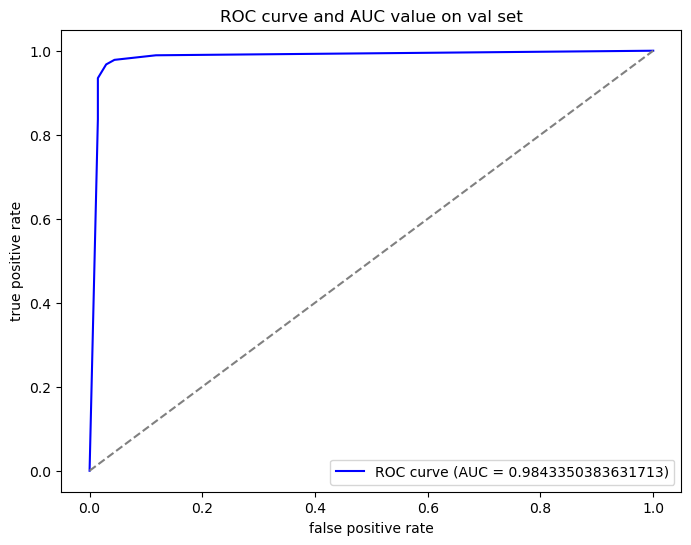

soft label distilled model performance metrics val set:
accuracy: 0.9688, logloss: 0.1197, precision: 0.9677, 
recall: 0.9783, F1 score: 0.9730

soft label distilled model performance metrics test set:
accuracy: 0.9450, logloss: 0.1806, precision: 0.9569, 
recall: 0.9487, F1 score: 0.9528


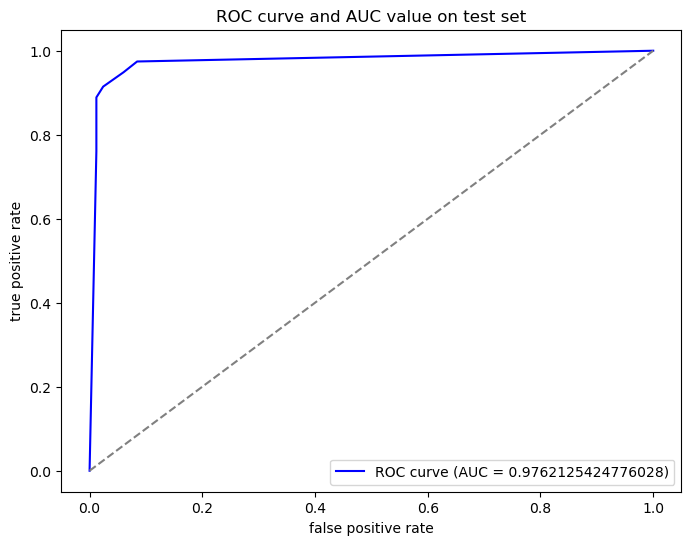

In [18]:
modelA_soft, y_pred_A = distill_softlabels(xgb_best, X_train, X_test, y_test)
#y_pred_A


Random Forest model distillation 



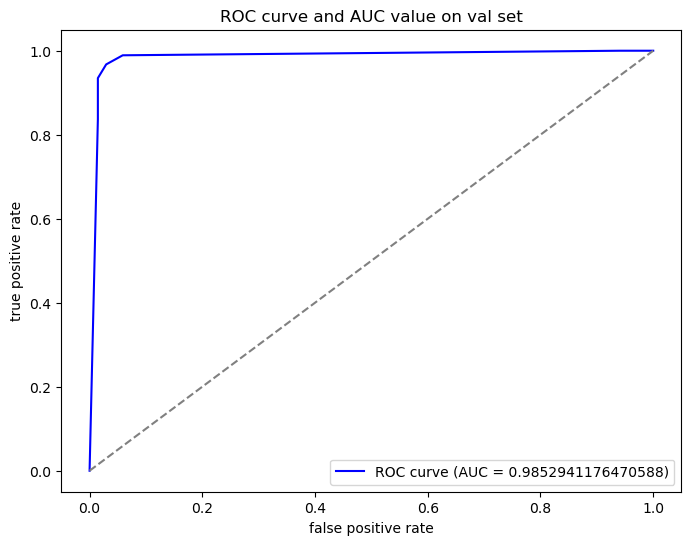

soft label distilled model performance metrics val set:
accuracy: 0.9688, logloss: 0.1078, precision: 0.9579, 
recall: 0.9891, F1 score: 0.9733

soft label distilled model performance metrics test set:
accuracy: 0.9600, logloss: 0.1467, precision: 0.9580, 
recall: 0.9744, F1 score: 0.9661


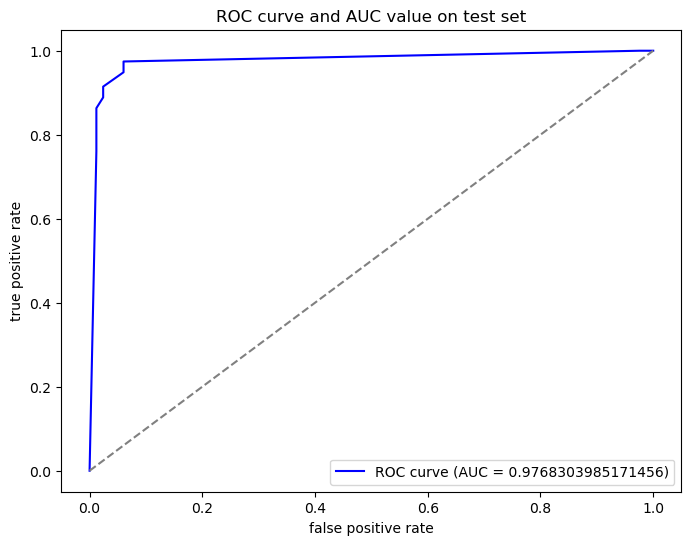

In [19]:
modelB_soft, y_pred_B = distill_softlabels(rf_best, X_train, X_test, y_test)


In [ ]:
#when an ROC curve rises sharply to the top left of the graph, its indicating of excellent performance. 
#this shape demonstrates a high true positive rate with a low false positive rate, meaning the model 
#effectively identifies positive cases while minimizing incorrect positives. in healthcare this is critical for detecting 
#diseases. a curve near the top left suggests high model reliability, with an AUC close to 1.0, indicating almost perfect 
#separability. this is essential for maintaining accuracy and trust, allowing for effective threshold adjustments.

# when limiting the depth of the DT the models start to appear to perform very similar. when trees are forced to focus on the 
# most straightforward path they tend to produce similar outputs. this results in a more generalized model but may also be 
# too simplified?? may also be a sign of a robust model??

# visualized trees

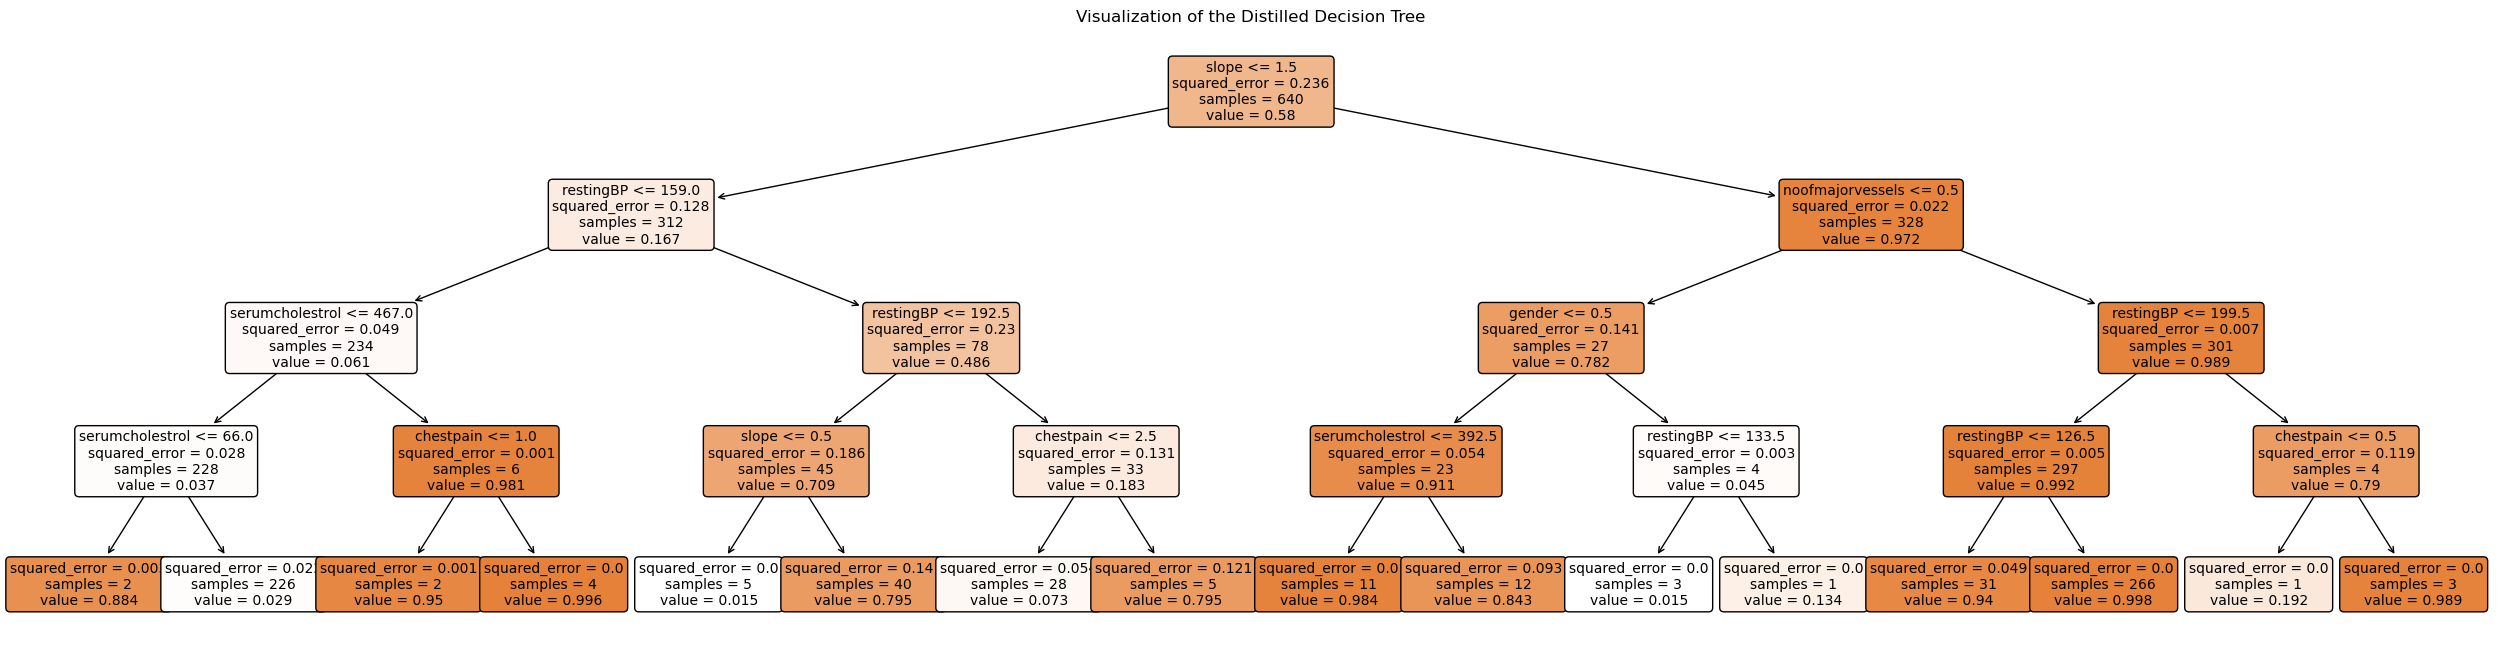

In [48]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

feature_names = X_train.columns.tolist()  

class_names = ['No Disease', 'Disease']

def visualize_decision_tree(model_student, feature_names, class_names=None):
    plt.figure(figsize=(32, 8))  
    plot_tree(
        model_student, 
        feature_names=feature_names,  
        class_names=class_names,      
        filled=True,                  
        rounded=True, 
        fontsize=10                   
    )

    plt.title("Visualization of the Distilled Decision Tree")
    plt.show()


visualize_decision_tree(modelA_soft, feature_names=feature_names)

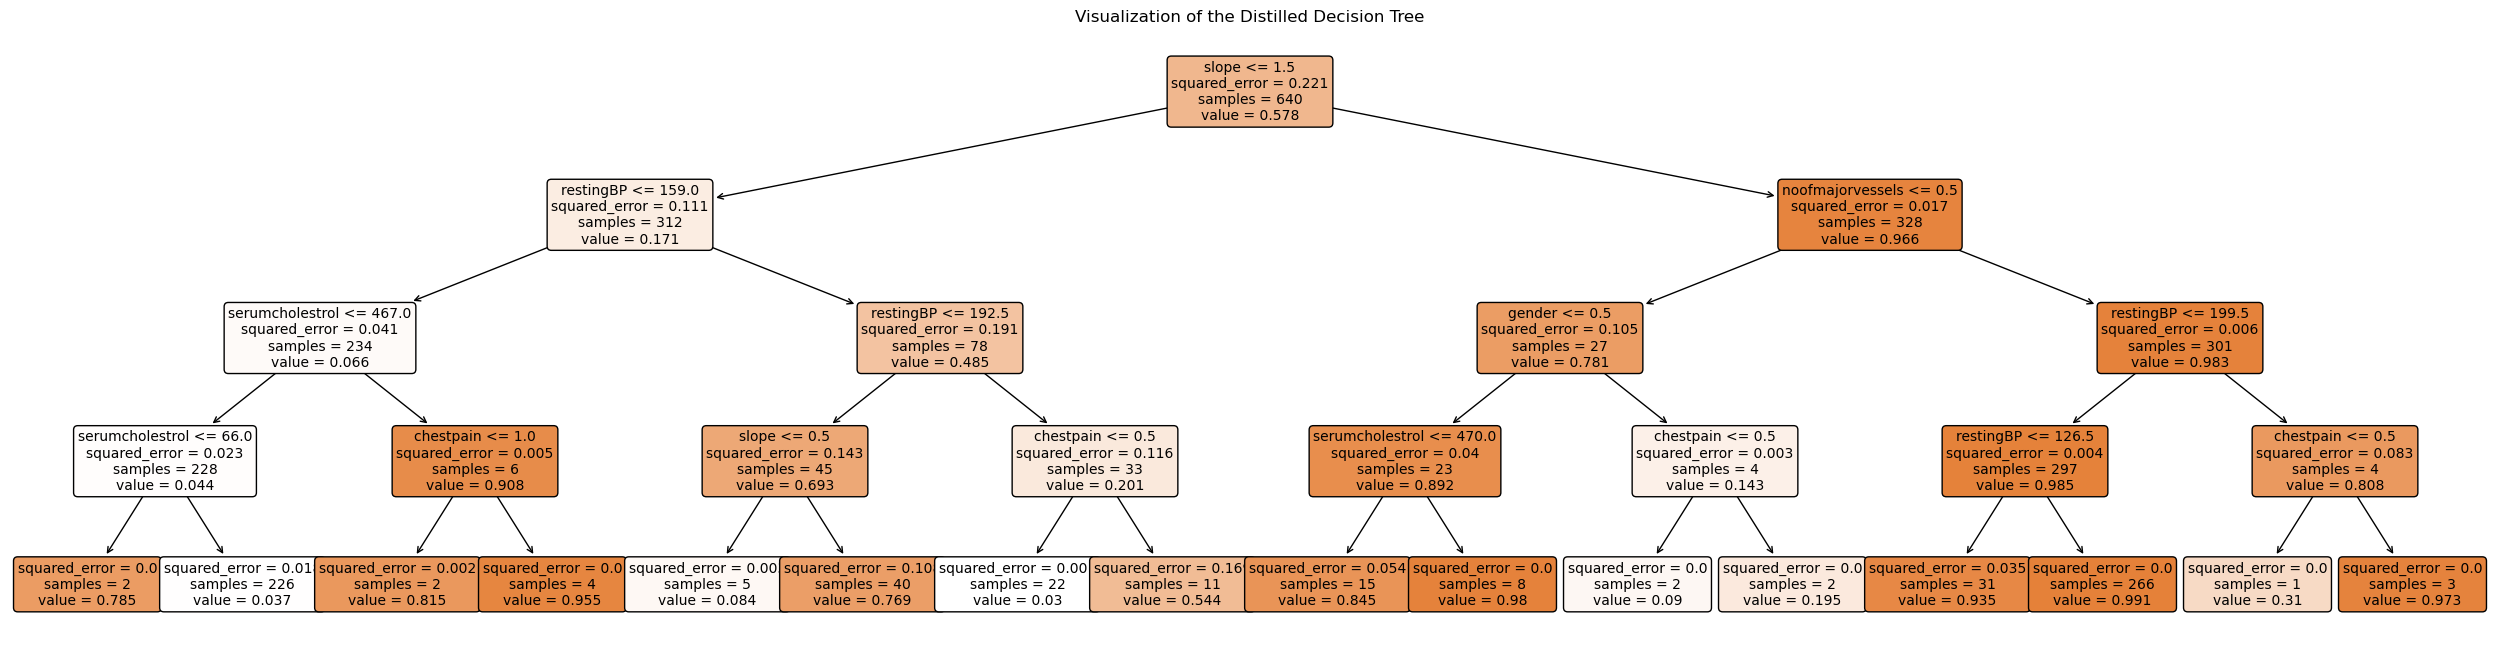

In [49]:
visualize_decision_tree(modelB_soft, feature_names=feature_names)

# error analysis

# analysis of teacher models

XGBoost Errors:
True Positives (TP): 114
True Negatives (TN): 81
False Positives (FP): 2
False Negatives (FN): 3

Random Forest Errors:
True Positives (TP): 117
True Negatives (TN): 82
False Positives (FP): 1
False Negatives (FN): 0
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        83
           1       0.98      0.97      0.98       117

    accuracy                           0.97       200
   macro avg       0.97      0.98      0.97       200
weighted avg       0.98      0.97      0.98       200

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        83
           1       0.99      1.00      1.00       117

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



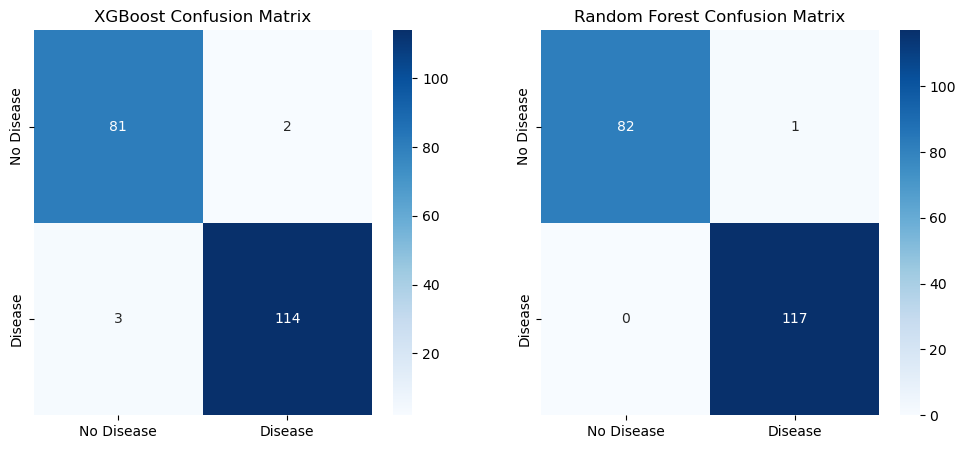

Misclassified Instances (XGBoost):
     True  Predicted_XGB  Predicted_RF  XGB_Error  RF_Error
947     1              0             1       True     False
439     1              0             1       True     False
570     0              1             0       True     False
764     1              0             1       True     False
867     0              1             1       True      True

Misclassified Instances (Random Forest):
     True  Predicted_XGB  Predicted_RF  XGB_Error  RF_Error
867     0              1             1       True      True


In [23]:
from sklearn.metrics import confusion_matrix, classification_report


results = pd.DataFrame({
    'True': y_test,
    'Predicted_XGB': xgb_y_pred,
    'Predicted_RF': rf_y_pred
})


results['XGB_Error'] = results['True'] != results['Predicted_XGB']
results['RF_Error'] = results['True'] != results['Predicted_RF']

confusion_xgb = confusion_matrix(y_test, xgb_y_pred)
confusion_rf = confusion_matrix(y_test, rf_y_pred)

tn_xgb, fp_xgb, fn_xgb, tp_xgb = confusion_xgb.ravel()

tn_rf, fp_rf, fn_rf, tp_rf = confusion_rf.ravel()

print("XGBoost Errors:")
print(f"True Positives (TP): {tp_xgb}")
print(f"True Negatives (TN): {tn_xgb}")
print(f"False Positives (FP): {fp_xgb}")
print(f"False Negatives (FN): {fn_xgb}")

print("\nRandom Forest Errors:")
print(f"True Positives (TP): {tp_rf}")
print(f"True Negatives (TN): {tn_rf}")
print(f"False Positives (FP): {fp_rf}")
print(f"False Negatives (FN): {fn_rf}")


print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_y_pred))

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_y_pred))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_xgb, annot=True, fmt='d', ax=axes[0], cmap='Blues', 
            xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
axes[0].set_title('XGBoost Confusion Matrix')

sns.heatmap(confusion_rf, annot=True, fmt='d', ax=axes[1], cmap='Blues', 
            xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
axes[1].set_title('Random Forest Confusion Matrix')

plt.show()

misclassified_xgb = results[results['XGB_Error']]
misclassified_rf = results[results['RF_Error']]

print("Misclassified Instances (XGBoost):")
print(misclassified_xgb)

print("\nMisclassified Instances (Random Forest):")
print(misclassified_rf)




In [ ]:
# is n 867 an outlier ??

# analysis of distilled models

Model A Errors:
True Positives (TP): 111
True Negatives (TN): 78
False Positives (FP): 5
False Negatives (FN): 6

Model B Errors:
True Positives (TP): 114
True Negatives (TN): 78
False Positives (FP): 5
False Negatives (FN): 3
modelA Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93        83
           1       0.96      0.95      0.95       117

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.95      0.94      0.95       200

modelB Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        83
           1       0.96      0.97      0.97       117

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200



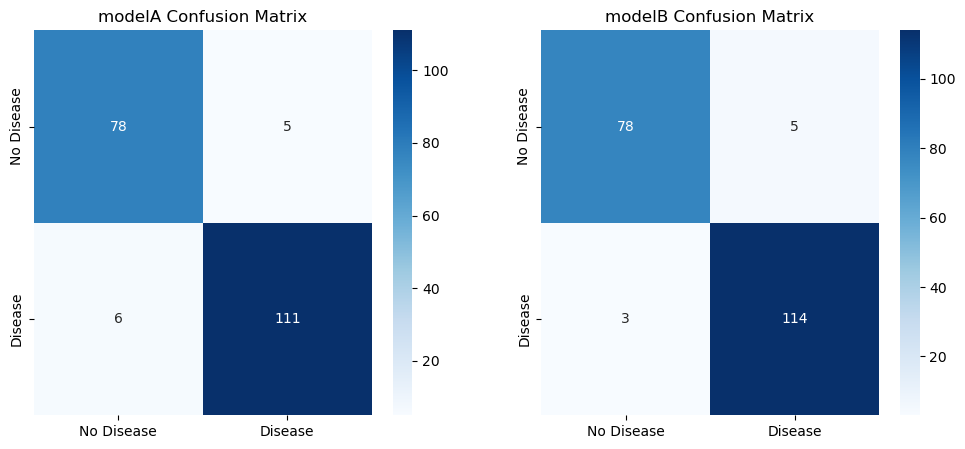

Misclassified Instances (modelA):
     True  Predicted_modelA  Predicted_modelB  modelA_Error  modelB_Error
660     0                 1                 1          True          True
947     1                 0                 0          True          True
901     0                 1                 1          True          True
924     0                 1                 1          True          True
570     0                 1                 1          True          True
543     0                 1                 1          True          True
764     1                 0                 1          True         False
534     1                 0                 0          True          True
260     1                 0                 1          True         False
429     1                 0                 0          True          True
365     1                 0                 1          True         False

Misclassified Instances (modelB):
     True  Predicted_modelA  Predicted_mode

In [22]:

results = pd.DataFrame({
    'True': y_test,
    'Predicted_modelA': y_pred_A,
    'Predicted_modelB': y_pred_B
})

results['modelA_Error'] = results['True'] != results['Predicted_modelA']
results['modelB_Error'] = results['True'] != results['Predicted_modelB']

confusion_A = confusion_matrix(y_test, y_pred_A)
confusion_B = confusion_matrix(y_test, y_pred_B)

tn_A, fp_A, fn_A, tp_A = confusion_A.ravel()
tn_B, fp_B, fn_B, tp_B = confusion_B.ravel()

print("Model A Errors:")
print(f"True Positives (TP): {tp_A}")
print(f"True Negatives (TN): {tn_A}")
print(f"False Positives (FP): {fp_A}")
print(f"False Negatives (FN): {fn_A}")

print("\nModel B Errors:")
print(f"True Positives (TP): {tp_B}")
print(f"True Negatives (TN): {tn_B}")
print(f"False Positives (FP): {fp_B}")
print(f"False Negatives (FN): {fn_B}")

print("modelA Classification Report:")
print(classification_report(y_test, y_pred_A))

print("modelB Classification Report:")
print(classification_report(y_test, y_pred_B))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_A, annot=True, fmt='d', ax=axes[0], cmap='Blues', 
            xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
axes[0].set_title('modelA Confusion Matrix')

sns.heatmap(confusion_B, annot=True, fmt='d', ax=axes[1], cmap='Blues', 
            xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
axes[1].set_title('modelB Confusion Matrix')

plt.show()

misclassified_A = results[results['modelA_Error']]
misclassified_B = results[results['modelB_Error']]

print("Misclassified Instances (modelA):")
print(misclassified_A)

print("\nMisclassified Instances (modelB):")
print(misclassified_B)

In [ ]:
# both teacher models classified instance 867 wrong but the distilled models somehow got it right?
# it seems that distilling the models in a DT adds a layer of complexity or learns the data in a dif way?